# **Exploración de datos**

Exploración de datos de admisiones y notas médicas, incluyendo preprocesamiento. Para reproducibilidad en Colab, usamos subconjuntos de datos, pero se presentan gráficos generados con el conjunto completo.

## 1. Configuración inicial

In [1]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Estilo de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Stopwords de NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsierra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Cargar datos

In [ ]:
# Archivo de muestra
discharge_path = 'otros/data/discharge_subset.csv.gz'
admissions_path = 'otros/data/admissions_subset.csv.gz'

# Leer subconjuntos
df_1 = pd.read_csv(discharge_path)
df_2 = pd.read_csv(admissions_path)

# Datos cargados
print("Primeras filas de las notas médicas:")
display(df_1.head())
print("Primeras filas de las admisiones:")
display(df_2.head())

Primeras filas de las notas médicas:


,hadm_id,text
0,28736349,\nName: ___ Unit No: __...
1,27383409,\nName: ___ Unit No: ___\n...
2,27871553,\nName: ___ Unit No: ___...
3,24081862,\nName: ___. Unit No: ___\n...
4,29709912,\nName: ___ Unit No: ___\n...


Primeras filas de las admisiones:


,hadm_id,admittime,dischtime
0,28736349,2173-11-09 15:20:00,2173-11-11 18:35:00
1,27383409,2196-11-11 07:22:00,2196-11-13 18:57:00
2,27871553,2141-05-08 00:00:00,2141-05-10 16:15:00
3,24081862,2149-10-11 14:30:00,2149-10-14 10:35:00
4,29709912,2154-09-25 23:05:00,2154-09-26 15:37:00


### Resultados sobre el conjunto de datos original

#### Primeras filas de las notas médicas sobre datos originales

| **note_id**          | **subject_id** | **hadm_id** | **note_type** | **note_seq** | **charttime**          | **storetime**          | **text**                  |
|-----------------------|----------------|-------------|---------------|--------------|------------------------|------------------------|---------------------------|
| 10000032-DS-21       | 10000032       | 22595853    | DS            | 21           | 2180-05-07 00:00:00    | 2180-05-09 15:26:00    | Name: ___ Unit No: _...    |
| 10000032-DS-22       | 10000032       | 22841357    | DS            | 22           | 2180-06-27 00:00:00    | 2180-07-01 10:15:00    | Name: ___ Unit No: _...    |
| 10000032-DS-23       | 10000032       | 29079034    | DS            | 23           | 2180-07-25 00:00:00    | 2180-07-25 21:42:00    | Name: ___ Unit No: _...    |
| 10000032-DS-24       | 10000032       | 25742920    | DS            | 24           | 2180-08-07 00:00:00    | 2180-08-10 05:43:00    | Name: ___ Unit No: _...    |
| 10000084-DS-17       | 10000084       | 23052089    | DS            | 17           | 2160-11-25 00:00:00    | 2160-11-25 15:09:00    | Name: ___ Unit No: __...   |

#### Primeras filas de las admisiones

| **subject_id** | **hadm_id** | **admittime**          | **dischtime**         | **deathtime** | **admission_type** | **admit_provider_id** | **admission_location**   | **discharge_location** | **insurance** | **language** | **marital_status** | **race** | **edregtime**         | **edouttime**         | **hospital_expire_flag** |
|----------------|-------------|------------------------|-----------------------|---------------|--------------------|-----------------------|--------------------------|-----------------------|---------------|--------------|--------------------|----------|-----------------------|-----------------------|---------------------------|
| 10000032       | 22595853    | 2180-05-06 22:23:00   | 2180-05-07 17:15:00   | NaN           | URGENT             | P874LG                | TRANSFER FROM HOSPITAL  | HOME                 | Other         | ENGLISH      | WIDOWED           | WHITE    | 2180-05-06 19:17:00   | 2180-05-06 23:30:00   | 0                         |
| 10000032       | 22841357    | 2180-06-26 18:27:00   | 2180-06-27 18:49:00   | NaN           | EW EMER.           | P09Q6Y                | EMERGENCY ROOM          | HOME                 | Medicaid      | ENGLISH      | WIDOWED           | WHITE    | 2180-06-26 15:54:00   | 2180-06-26 21:31:00   | 0                         |
| 10000032       | 25742920    | 2180-08-05 23:44:00   | 2180-08-07 17:50:00   | NaN           | EW EMER.           | P60CC5                | EMERGENCY ROOM          | HOSPICE              | Medicaid      | ENGLISH      | WIDOWED           | WHITE    | 2180-08-05 20:58:00   | 2180-08-06 01:44:00   | 0                         |
| 10000032       | 29079034    | 2180-07-23 12:35:00   | 2180-07-25 17:55:00   | NaN           | EW EMER.           | P30KEH                | EMERGENCY ROOM          | HOME                 | Medicaid      | ENGLISH      | WIDOWED           | WHITE    | 2180-07-23 05:54:00   | 2180-07-23 14:00:00   | 0                         |
| 10000068       | 25022803    | 2160-03-03 23:16:00   | 2160-03-04 06:26:00   | NaN           | EU OBSERVATION      | P51VDL                | EMERGENCY ROOM          | NaN                  | Other         | ENGLISH      | SINGLE            | WHITE    | 2160-03-03 21:55:00   | 2160-03-04 06:26:00   | 0                         |

## 3. Combinar datasets y generar variables objetivo

In [3]:
# Combinar los datasets
df = pd.merge(df_1[['hadm_id', 'text']], 
              df_2[['hadm_id', 'admittime', 'dischtime']], 
              on='hadm_id')

# Revisar tipos de variables
df['text'] = df['text'].astype(str)
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

# Variable de tiempo de estancia (en días)
df['los'] = (df['dischtime'] - df['admittime']).dt.days

# Variable binaria: estancia < 7 días -> 0, >= 7 días -> 1
df['blos'] = np.where(df['los'] < 7, 0, 1)

# Limpiar el dataframe
df = df.drop(['admittime', 'dischtime'], axis='columns')
df = df.dropna()

# Mostrar información de los datos procesados
print("Información de los datos combinados y preprocesados:")
df.info()

Información de los datos combinados y preprocesados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hadm_id  1000 non-null   int64 
 1   text     1000 non-null   object
 2   los      1000 non-null   int64 
 3   blos     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


### Información de los datos originales combinados

#### Detalle de las columnas

| **#** | **Nombre de la columna** | **Conteo no nulo** | **Tipo de dato** |
|-------|---------------------------|--------------------|------------------|
| 0     | hadm_id                  | 331793             | int64            |
| 1     | text                     | 331793             | object           |
| 2     | los                      | 331793             | int64            |
| 3     | blos                     | 331793             | int64            |

#### Uso de memoria

El DataFrame ocupa aproximadamente **10.1 MB** de memoria.

## 4. Preprocesamiento del texto

In [4]:
# Inicializar las stopwords y el stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Funciones para limpieza del texto
def clean_text(text):
    text = text.lower()  # Texto a minúsculas
    text = re.sub('[^a-zA-Z0-9\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text)  # Reemplazar múltiples espacios por uno
    text = re.sub(r'_+', '[REMOVED]', text)  # Reemplazar guiones bajos repetidos por palabre [REMOVED]
    return text

# Aplicar limpieza y stemming
def remove_stopwords_and_stem(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(stemmed_words)

df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(remove_stopwords_and_stem)

# Ejemplo de texto procesado
print("Ejemplo de texto procesado:")
print(df['text'][0])

Ejemplo de texto procesado:
name unit admiss date discharg date date birth sex f servic medicin allergi anticholinergicsoth reglan attend chief complaint abdomin pain major surgic invas procedur none histori present ill patient yo woman histori chronic pancreat sp cholecystectomi sphincterotomi present 1wk worsen abdomin pain per patient pain intermitt sharp qualiti local midrigh upper abdomen radiat chest wall back patient find pain similar prior pancreat flareup deni precipit includ alcohol use abd trauma infect ho gallston note restrict diet caffeinefatti foodfri fooddairi part pancreat manag also note pain worsen meal allevi npo nsaid dilaudid patient init seen pcp worsen pain treat po zofran nsaid pain fail improv present ed ed vital 996 hr 77 bp 10456 rr 16 o2 sat 98 ra patient receiv 8 mg iv morphin zofran admit medicin pain control past medic histori 1 chronic pancreat first episod pt laparoscop cholecystectomi dietari modif ercp w sphincterotomi recent flare pt respond iv hydr

## 5. Análisis descriptivo

### 5.1 Distribución del tiempo de estancia

Estadísticas descriptivas del tiempo de estancia (en días):
count    1000.000000
mean        5.332000
std         8.259055
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       101.000000
Name: los, dtype: float64


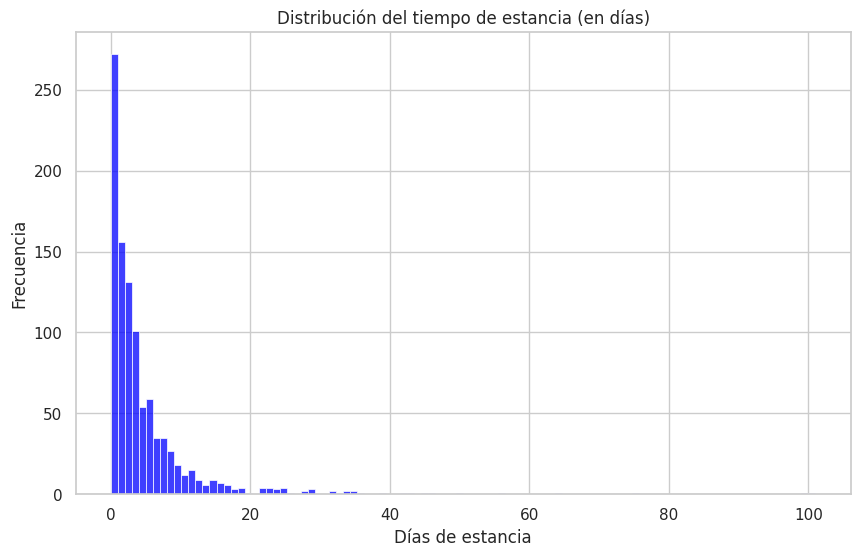

In [5]:
# Descripcion
print("Estadísticas descriptivas del tiempo de estancia (en días):")
print(df['los'].describe())

# Histograma de la distribución del tiempo de estancia
plt.figure()
sns.histplot(df['los'], bins=100, color='blue')
plt.title("Distribución del tiempo de estancia (en días)")
plt.xlabel("Días de estancia")
plt.ylabel("Frecuencia")
plt.show()

#### Estadísticas descriptivas del tiempo de estancia (en días) datos originales

El siguiente resumen presenta las estadísticas descriptivas de la variable **`los`** (longitud de estancia en días):

| **Métrica**       | **Valor**       |
|--------------------|-----------------|
| **Conteo**         | 331,793         |
| **Media**          | 4.915          |
| **Desviación estándar** | 7.198       |
| **Mínimo**         | 0.000          |
| **Percentil 25**   | 1.000          |
| **Mediana (Percentil 50)** | 3.000    |
| **Percentil 75**   | 6.000          |
| **Máximo**         | 295.000        |

#### Distribución del Tiempo de Estancia

![Distribución del tiempo de estancia](otros/length_of_stay_distribution.png)

### 5.2 Distribución del tiempo de estancia binaria

Frecuencia de las categorías de tiempo de estancia binaria:
blos
0    773
1    227
Name: count, dtype: int64


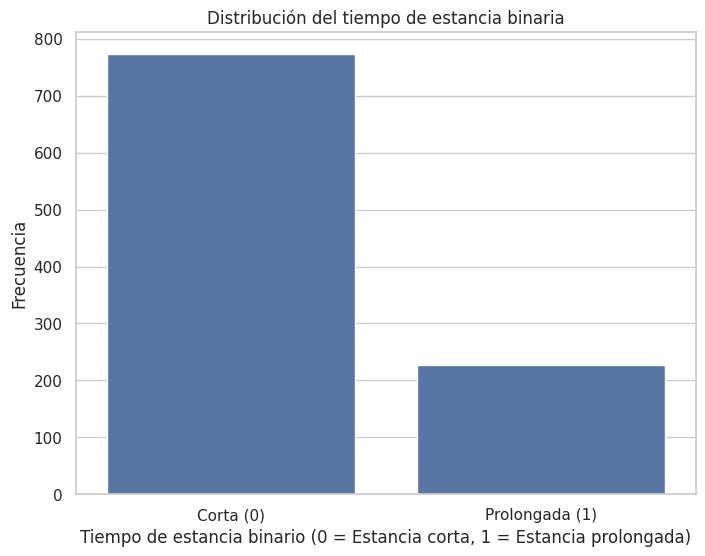

In [6]:
# Contar las frecuencias de las categorías de la variable binaria 'blos'
blos_counts = df['blos'].value_counts()

# Mostrar las frecuencias
print("Frecuencia de las categorías de tiempo de estancia binaria:")
print(blos_counts)

# Graficar la distribución de la variable binaria
plt.figure(figsize=(8, 6))
sns.countplot(x='blos', data=df)
plt.title("Distribución del tiempo de estancia binaria")
plt.xlabel("Tiempo de estancia binario (0 = Estancia corta, 1 = Estancia prolongada)")
plt.ylabel("Frecuencia")
plt.xticks(ticks=[0, 1], labels=["Corta (0)", "Prolongada (1)"])
plt.show()

#### **Distribución de las Categorías del Tiempo de Estancia Binario sobre datos originales**

La variable binaria `blos` clasifica los tiempos de estancia en dos categorías:
- **Corta estancia** (`0`): Menos de 7 días.  
- **Estancia prolongada** (`1`): 7 días o más.

A continuación, se muestra la frecuencia de cada categoría:

| Categoría (`blos`) | Frecuencia |
|---------------------|------------|
| 0 (Corta estancia)  | 261,085    |
| 1 (Estancia prolongada) | 70,708 |

#### Distribución del Tiempo de Estancia Binario

![Distribución del tiempo de estancia binario](otros/binary_length_of_stay_distribution.png)

### 5.3 Distribución de la longitud de las notas médicas

Estadísticas descriptivas de la longitud de las notas médicas:


count    1000.000000
mean     1115.934000
std       451.458754
min       155.000000
25%       775.000000
50%      1055.500000
75%      1391.500000
max      3890.000000
Name: note_length, dtype: float64


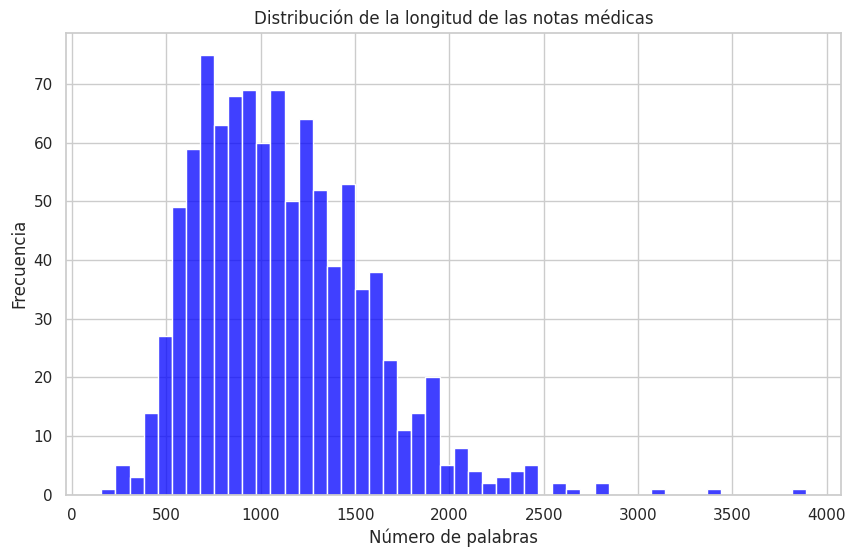

In [7]:
# Calcular la longitud de las notas médicas (número de palabras en cada nota)
plot_df = pd.DataFrame([])
plot_df['note_length'] = df['text'].apply(lambda x: len(x.split()))

# Estadísticas descriptivas de la longitud de las notas
print("Estadísticas descriptivas de la longitud de las notas médicas:")
print(plot_df['note_length'].describe())

# Histograma de la distribución de la longitud de las notas médicas
plt.figure(figsize=(10, 6))
sns.histplot(plot_df['note_length'], bins=50, color='blue')
plt.title("Distribución de la longitud de las notas médicas")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

#### Estadísticas descriptivas de la longitud de las notas médicas sobre datos originales

| Medida   | Valor       |
|----------|-------------|
| **count** | 331,793     |
| **mean**  | 1,095.99    |
| **std**   | 450.36      |
| **min**   | 30          |
| **25%**   | 779         |
| **50%**   | 1,033       |
| **75%**   | 1,339       |
| **max**   | 6,029       |

#### Distribución de la longitud de las notas médicas

![Distribución de la longitud de las notas médicas](otros/note_length_distribution.png)